In [1]:
# import autosklearn.classification
from pipeline import *

# pipeline_year(10)

df_coaches = pd.read_csv('dataset/cleaned/coaches.csv')
models = [
    lambda: RandomForestClassifier(n_estimators=100, random_state=42),
    #lambda: LogisticRegression(max_iter=1000, random_state=42),
    lambda: SVC(C=1.0, kernel='rbf', probability=True),
    lambda: GaussianNB(),
    lambda: KNeighborsClassifier(n_neighbors=5),
    lambda: DecisionTreeClassifier(max_depth=5, random_state=42),
    lambda: GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    lambda: MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
]

def run_window_decay(model, year):
    l = []

    # param_grids = [
    #     {
    #         'n_estimators': [100, 200, 300],
    #         'max_depth': [5, 10, None],
    #         'min_samples_split': [2, 5, 10],
    #         'random_state': [42]
    #     },
    #     {
    #         'C': [1.0, 0.1, 0.01],
    #         'kernel': ['rbf', 'linear'],
    #         'probability': [True]
    #     },
    #     {},
    #     {
    #         'n_neighbors': [5, 10, 15],
    #         'weights': ['uniform', 'distance']
    #     },
    #     {
    #         'max_depth': [5, 10, 15],
    #         'min_samples_split': [2, 5, 10],
    #         'random_state': [42]
    #     },
    #     {
    #         'n_estimators': [100, 200, 300],
    #         'learning_rate': [0.1, 0.01, 0.001],
    #         'max_depth': [3, 5, 7],
    #         'random_state': [42]
    #     },
    #     {
    #         'hidden_layer_sizes': [(100, 50), (200, 100), (300, 150)],
    #         'max_iter': [1000, 2000, 3000],
    #         'random_state': [42]
    #     }
    #     ]

    clf = model()
    decay_rate=0.1
    df_teams_merged = []
    test = []
    train = []
    for i in range(2, year + 1):
        df_teams_merged = pipeline_clf(year=i)
        weight = decay_rate ** (10 - i - 1)

        df_teams_merged['confID'] = df_teams_merged['confID'].replace({'EA': 0, 'WE': 1})

        train = df_teams_merged[df_teams_merged['year'] < i]
        test = df_teams_merged[df_teams_merged['year'] == i]

        #if (year == i):
        #    break


        X_train = train[train.drop(['playoff', 'year', 'tmID'], axis=1).columns]
        y_train = train['playoff']
        sample_weight = [weight] * len(X_train)

        # grid_search_results = []
        # best_model = None
        # best_score = 0

        # # Perform grid search for each model
        # for model, param_grid in zip(models, param_grids):
        #     grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
        #     grid_search.fit(train.drop(['playoff', 'year', 'tmID'], axis=1), train['playoff'])  # Replace X and y with your data
        #     grid_search_results.append(grid_search)
        #     if grid_search.best_score_ > best_score:
        #         best_score = grid_search.best_score_
        #         best_model = grid_search.best_estimator_

        # for model, grid_search_result in zip(models, grid_search_results):
        #     print(f"Best parameters for {model.__class__.__name__}: {grid_search_result.best_params_}")
        #     print(f"Best score for {model.__class__.__name__}: {grid_search_result.best_score_}")

        # clf = best_model

        if type(model()).__name__ in ["KNeighborsClassifier", "MLPClassifier"]:
            clf.fit(X_train, y_train)  # This model don't support sample weights
        else:
            clf.fit(X_train, y_train, sample_weight=sample_weight)

    predictions = clf.predict_proba(test.drop(['playoff', 'year', 'tmID'], axis=1))[:, 1]
    test['predictions'] = predictions
    df_teams_merged['predictions'] = 0
    df_teams_merged.loc[df_teams_merged['year'] == year, 'predictions'] = predictions

    df_teams_merged['confID'] = df_teams_merged['confID'].replace({0: 'EA', 1 : 'WE'})

    # print the year and the predicted scores
    # print(df_teams_merged[df_teams_merged['year'] == year][['tmID', 'confID', 'predictions', 'awards', 'offensive_strength']].sort_values(by='predictions', ascending=False))


    df_teams, ea_teams, we_teams = classify_playoff_entry(
            df_teams_merged, year)

    ea_predictions = ea_teams['tmID'].unique()
    we_predictions = we_teams['tmID'].unique()


    accuracy = calculate_playoff_accuracy(
        year, ea_predictions, we_predictions, display_results = False)

    return accuracy


    tmID  year  offensive_strength  defensive_strength confID  playoff   
26   CON    11            0.869045            0.788144     EA      0.0  \
56   IND    11            1.093206            1.203242     EA      1.0   
92   NYL    11            0.441216            0.290111     EA      1.0   
2    ATL    11            0.091686            0.089444     EA      1.0   
14   CHI    11            0.359402            0.447541     EA      0.0   
153  WAS    11            0.396034            0.399958     EA      1.0   

     win_percentage_coach  awards  predictions  
26               1.180247  0.0625     1.000000  
56              -0.101166  0.3750     1.000000  
92               1.291558  0.1250     0.580645  
2               -0.994404  0.1875     0.050000  
14               0.000000  0.0625     0.050000  
153             -0.559367  0.1250     0.050000  
    tmID  year  offensive_strength  defensive_strength confID  playoff   
67   LAS    11            1.153442            1.322111     WE   

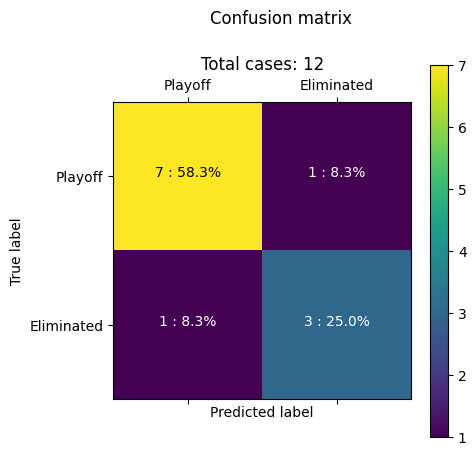

87.5

In [2]:
pipeline_year(11,display_results=True, model=models[4])

    tmID  year  offensive_strength  defensive_strength confID  playoff   
26   CON    11            0.869045            0.788144     EA      0.0  \
92   NYL    11            0.441216            0.290111     EA      1.0   
56   IND    11            1.093206            1.203242     EA      1.0   
14   CHI    11            0.359402            0.447541     EA      0.0   
153  WAS    11            0.396034            0.399958     EA      1.0   
2    ATL    11            0.091686            0.089444     EA      1.0   

     win_percentage_coach  awards  predictions  
26               1.180247  0.0625     0.808184  
92               1.291558  0.1250     0.756524  
56              -0.101166  0.3750     0.726925  
14               0.000000  0.0625     0.435339  
153             -0.559367  0.1250     0.244985  
2               -0.994404  0.1875     0.218834  
    tmID  year  offensive_strength  defensive_strength confID  playoff   
138  SEA    11            1.416331            1.103757     WE   

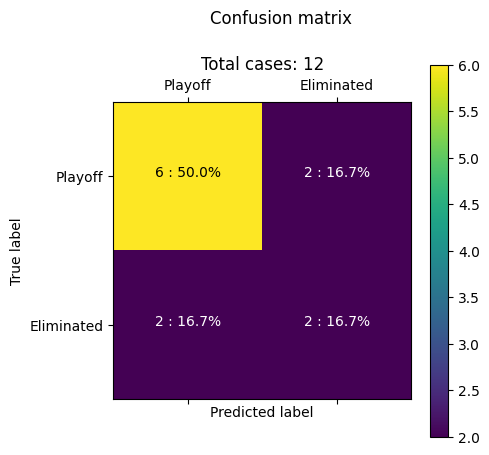

75.0

In [3]:
pipeline_year(11,display_results=True, model=models[1])

    tmID  year  offensive_strength  defensive_strength confID  playoff   
56   IND    11            1.093206            1.203242     EA      1.0  \
26   CON    11            0.869045            0.788144     EA      0.0   
92   NYL    11            0.441216            0.290111     EA      1.0   
14   CHI    11            0.359402            0.447541     EA      0.0   
2    ATL    11            0.091686            0.089444     EA      1.0   
153  WAS    11            0.396034            0.399958     EA      1.0   

     win_percentage_coach  awards  predictions  
56              -0.101166  0.3750         0.88  
26               1.180247  0.0625         0.79  
92               1.291558  0.1250         0.60  
14               0.000000  0.0625         0.35  
2               -0.994404  0.1875         0.15  
153             -0.559367  0.1250         0.06  
    tmID  year  offensive_strength  defensive_strength confID  playoff   
67   LAS    11            1.153442            1.322111     WE   

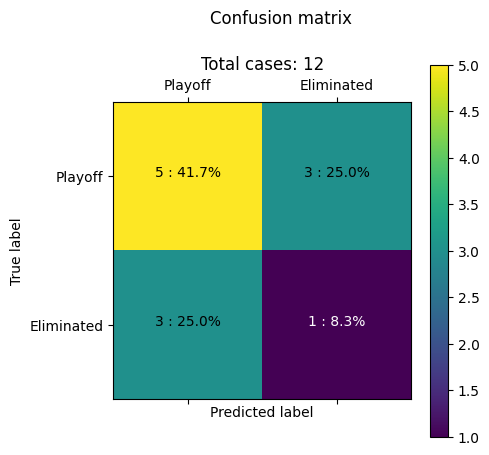

62.5

In [4]:
pipeline_year(11,display_results=True, model=models[0])

    tmID  year  offensive_strength  defensive_strength confID  playoff   
56   IND    11            1.093206            1.203242     EA      1.0  \
26   CON    11            0.869045            0.788144     EA      0.0   
92   NYL    11            0.441216            0.290111     EA      1.0   
14   CHI    11            0.359402            0.447541     EA      0.0   
2    ATL    11            0.091686            0.089444     EA      1.0   
153  WAS    11            0.396034            0.399958     EA      1.0   

     win_percentage_coach  awards  predictions  
56              -0.101166  0.3750         0.88  
26               1.180247  0.0625         0.79  
92               1.291558  0.1250         0.60  
14               0.000000  0.0625         0.35  
2               -0.994404  0.1875         0.15  
153             -0.559367  0.1250         0.06  
    tmID  year  offensive_strength  defensive_strength confID  playoff   
67   LAS    11            1.153442            1.322111     WE   

c:\Users\ricar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


    tmID  year  offensive_strength  defensive_strength confID  playoff   
26   CON    11            0.869045            0.788144     EA      0.0  \
56   IND    11            1.093206            1.203242     EA      1.0   
14   CHI    11            0.359402            0.447541     EA      0.0   
92   NYL    11            0.441216            0.290111     EA      1.0   
153  WAS    11            0.396034            0.399958     EA      1.0   
2    ATL    11            0.091686            0.089444     EA      1.0   

     win_percentage_coach  awards   predictions  
26               1.180247  0.0625  9.999300e-01  
56              -0.101166  0.3750  9.048197e-01  
14               0.000000  0.0625  5.693648e-01  
92               1.291558  0.1250  3.416132e-02  
153             -0.559367  0.1250  6.092156e-03  
2               -0.994404  0.1875  4.176377e-09  
    tmID  year  offensive_strength  defensive_strength confID  playoff   
138  SEA    11            1.416331            1.103757   

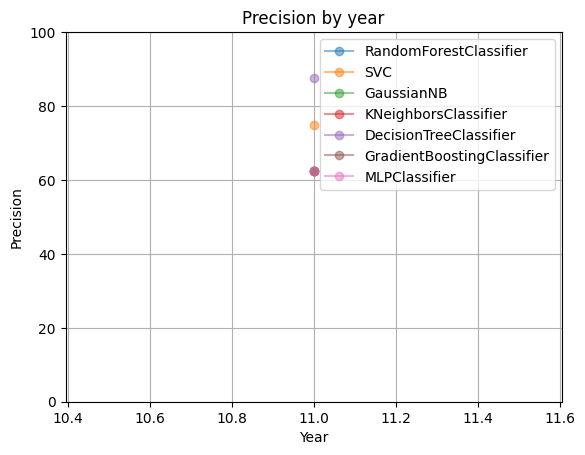

In [5]:
from pipeline import *

def check_accuracy_by_year2(models):
    # Create a list to store accuracy values for each model
    accs = []
    
    # Define the years
    years = list(range(11, 12))
    
    # Calculate accuracy for each year for each model
    for model in models:
        #model_accs = [run_window_decay(model, year) for year in years]
        model_accs = [pipeline_year(year, model=model, display_results=False) for year in years]
        accs.append(model_accs)
    #accs = [[75.0, 50.0, 75.0, 75.0, 87.5, 87.5, 62.5, 87.5, 87.5], [50.0, 50.0, 87.5, 50.0, 62.5, 25.0, 62.5, 62.5, 75.0], [62.5, 50.0, 62.5, 75.0, 75.0, 87.5, 62.5, 75.0, 87.5], [50.0, 50.0, 62.5, 62.5, 62.5, 87.5, 62.5, 62.5, 75.0], [62.5, 50.0, 87.5, 62.5, 75.0, 75.0, 62.5, 50.0, 75.0], [50.0, 50.0, 50.0, 87.5, 75.0, 87.5, 62.5, 62.5, 87.5], [62.5, 50.0, 50.0, 75.0, 75.0, 100.0, 62.5, 87.5, 75.0]]
    print(accs)

    # Plot the accuracy line graphs for each model
    for i, model_acc in enumerate(accs):
        plt.plot(years, model_acc, label=f"{type(models[i]()).__name__ }", marker='o', linestyle='-', alpha=0.5)

    # Add labels for each data point
    # for i, model_acc in enumerate(accs):
    #     for j, acc in enumerate(model_acc):
    #         plt.text(years[j], acc, f"{acc:.2f}", ha="center", va="bottom")

    # Add legend
    plt.legend()

    # Set Y-axis limits
    plt.ylim(0, 100)

    plt.xlabel("Year")
    plt.ylabel("Precision")
    plt.title("Precision by year")
    plt.grid(True)

    plt.show()

check_accuracy_by_year2(models)


In [6]:
run_window_decay(models[0], 10)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "C:\Users\ricar\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3460, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\ricar\AppData\Local\Temp\ipykernel_28124\3787077956.py", line 1, in <module>
    run_window_decay(models[0], 10)
  File "C:\Users\ricar\AppData\Local\Temp\ipykernel_28124\3957204708.py", line 62, in run_window_decay
    df_teams_merged = pipeline_clf(year=i)
  File "c:\Users\ricar\OneDrive\Ambiente de Trabalho\ac\pipeline.py", line 271, in pipeline_clf
    df_teams_merged = global_merge(df_teams, df_teams_post, df_series_post,
  File "c:\Users\ricar\OneDrive\Ambiente de Trabalho\ac\pipeline.py", line 107, in global_merge
    df_players_teams = team_mean(df_players_teams, df_player_ratings, df_offensive_player_stats, df_defensive_player_stats)
  File "c:\Users\ricar\OneDrive\Ambiente de Trabalho\ac\funcs\statistical_analysis.py", line 47, in team_mean
    to

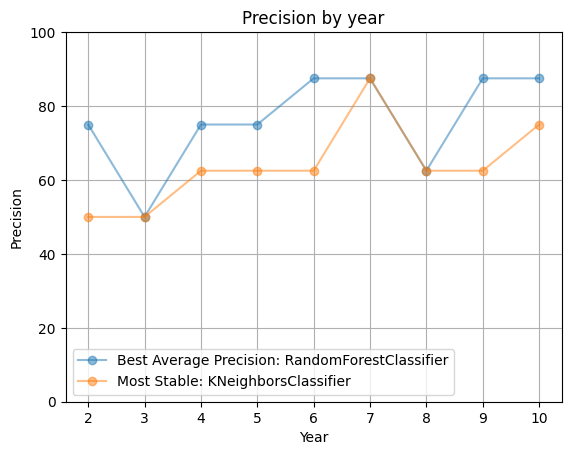

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

accs = [[75.0, 50.0, 75.0, 75.0, 87.5, 87.5, 62.5, 87.5, 87.5], [50.0, 50.0, 87.5, 50.0, 62.5, 25.0, 62.5, 62.5, 75.0], [62.5, 50.0, 62.5, 75.0, 75.0, 87.5, 62.5, 75.0, 87.5], [50.0, 50.0, 62.5, 62.5, 62.5, 87.5, 62.5, 62.5, 75.0], [62.5, 50.0, 87.5, 62.5, 75.0, 75.0, 62.5, 50.0, 75.0], [50.0, 50.0, 50.0, 87.5, 75.0, 87.5, 62.5, 62.5, 87.5], [62.5, 50.0, 50.0, 75.0, 75.0, 100.0, 62.5, 87.5, 75.0]]

years = list(range(2, 11))
model_names = [type(model()).__name__ for model in models]

# Calculate the average accuracy and standard deviation for each model
avg_accuracies = [np.mean(model_accs) for model_accs in accs]
std_accuracies = [np.std(model_accs) for model_accs in accs]

# Find the index of the model with the highest average accuracy and lowest standard deviation
best_avg_model_index = np.argmax(avg_accuracies)
most_stable_model_index = np.argmin(std_accuracies)

# Plot the accuracy line graphs for the best average model and the most stable model
plt.plot(years, accs[best_avg_model_index], label=f"Best Average Precision: {model_names[best_avg_model_index]}", marker='o', linestyle='-', alpha=0.5)
plt.plot(years, accs[most_stable_model_index], label=f"Most Stable: {model_names[most_stable_model_index]}", marker='o', linestyle='-', alpha=0.5)

# Add legend
plt.legend()

# Set Y-axis limits
plt.ylim(0, 100)

plt.xlabel("Year")
plt.ylabel("Precision")
plt.title("Precision by year")
plt.grid(True)

plt.show()